# Introduction
In order to classify threat data into the proper threat taxonomy, this research evaluates the performance of several classification-based machine learning algorithms using threat intelligence data gathered from 14 distinct open source threat feeds using IntelMQ. The aim is to construct a resilient model that can precisely categorise various threats by utilising relevant information derived from the data. The best peforming will be integrated in the Deakin threat Mirror platform.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1. Import Data

In [2]:
import json
import pandas as pd
import numpy as np

threat_data_raw = '/content/drive/MyDrive/Uni2024/Analytics4Privacy/dataset29.txt'

# handle json parsing issues, neglect the lines with error and proceed.
threat_data = []

with open(threat_data_raw, 'r') as file:
    for line in file:
        try:
            threat_data.append(json.loads(line))
        except json.JSONDecodeError:
            pass

# Convert to a DataFrame and display the datafrmae
threat_df = pd.DataFrame(threat_data)
threat_df

,classification.taxonomy,classification.type,event_description.text,feed.accuracy,feed.name,feed.provider,feed.url,protocol.application,source.abuse_contact,source.allocated,...,extra.blocklist,source.fqdn,source.port,source.url,source.urlpath,status,protocol.transport,extra.last_online,malware.name,source.reverse_dns
0,intrusion-attempts,brute-force,Address has been seen attempting to remotely l...,100.0,HTTP,Dataplane,https://dataplane.org/sshpwauth.txt,ssh,abuse@digitalocean.com,2018-07-12T00:00:00+00:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,intrusion-attempts,brute-force,Address has been seen attempting to remotely l...,100.0,HTTP,Dataplane,https://dataplane.org/sshpwauth.txt,ssh,abuse@digitalocean.com,2018-07-12T00:00:00+00:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,intrusion-attempts,brute-force,Address has been seen attempting to remotely l...,100.0,HTTP,Dataplane,https://dataplane.org/sshpwauth.txt,ssh,abuse@digitalocean.com,2020-01-17T00:00:00+00:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,intrusion-attempts,brute-force,Address has been seen attempting to remotely l...,100.0,HTTP,Dataplane,https://dataplane.org/sshpwauth.txt,ssh,abuse@digitalocean.com,2020-01-17T00:00:00+00:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,intrusion-attempts,brute-force,Address has been seen attempting to remotely l...,100.0,HTTP,Dataplane,https://dataplane.org/sshpwauth.txt,ssh,abuse@digitalocean.com,2020-01-17T00:00:00+00:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
289976,malicious-code,c2-server,NaN,100.0,Feodo Tracker,Abuse.ch,https://feodotracker.abuse.ch/downloads/ipbloc...,NaN,NaN,2009-07-21T00:00:00+00:00,...,NaN,NaN,60859.0,NaN,NaN,online,NaN,2023-11-20,pikabot,NaN
289977,malicious-code,c2-server,NaN,100.0,Feodo Tracker,Abuse.ch,https://feodotracker.abuse.ch/downloads/ipbloc...,NaN,NaN,2013-03-15T00:00:00+00:00,...,NaN,NaN,13721.0,NaN,NaN,online,NaN,2023-11-20,pikabot,172-233-156-100.ip.linodeusercontent.com
289978,malicious-code,c2-server,NaN,100.0,Feodo Tracker,Abuse.ch,https://feodotracker.abuse.ch/downloads/ipbloc...,NaN,NaN,2013-03-15T00:00:00+00:00,...,NaN,NaN,13721.0,NaN,NaN,online,NaN,2023-11-20,pikabot,172-233-156-100.ip.linodeusercontent.com
289979,malicious-code,c2-server,NaN,100.0,Feodo Tracker,Abuse.ch,https://feodotracker.abuse.ch/downloads/ipbloc...,NaN,NaN,2011-02-02T00:00:00+00:00,...,NaN,NaN,1194.0,NaN,NaN,offline,NaN,2023-11-19,pikabot,NaN


# 2. Feature Engineering: choose features that will be used for determining threat taxonomy

In [3]:
# Columns to include in the new DataFrame
columns_to_include = ['classification.taxonomy', 'classification.type','feed.name','source.network','protocol.application','source.ip']
# Create the new DataFrame with selected columns
df_ml = threat_df[columns_to_include]

df_ml

,classification.taxonomy,classification.type,feed.name,source.network,protocol.application,source.ip
0,intrusion-attempts,brute-force,HTTP,142.93.192.0/20,ssh,142.93.202.26
1,intrusion-attempts,brute-force,HTTP,142.93.192.0/20,ssh,142.93.206.129
2,intrusion-attempts,brute-force,HTTP,143.110.176.0/20,ssh,143.110.176.216
3,intrusion-attempts,brute-force,HTTP,143.110.176.0/20,ssh,143.110.188.217
4,intrusion-attempts,brute-force,HTTP,143.110.176.0/20,ssh,143.110.189.97
...,...,...,...,...,...,...
289976,malicious-code,c2-server,Feodo Tracker,91.215.85.0/24,NaN,91.215.85.154
289977,malicious-code,c2-server,Feodo Tracker,172.233.128.0/19,NaN,172.233.156.100
289978,malicious-code,c2-server,Feodo Tracker,172.233.128.0/19,NaN,172.233.156.100
289979,malicious-code,c2-server,Feodo Tracker,46.250.240.0/21,NaN,46.250.241.188


# 3. Treat Missing values

In [4]:
# # Replace missing values in 'protocol.application' with 'unknown' and displya the new data frame
df_ml.fillna(value={'protocol.application': 'unknown'}, inplace=True)
df_ml

<ipython-input-4-330585d81298>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ml.fillna(value={'protocol.application': 'unknown'}, inplace=True)


,classification.taxonomy,classification.type,feed.name,source.network,protocol.application,source.ip
0,intrusion-attempts,brute-force,HTTP,142.93.192.0/20,ssh,142.93.202.26
1,intrusion-attempts,brute-force,HTTP,142.93.192.0/20,ssh,142.93.206.129
2,intrusion-attempts,brute-force,HTTP,143.110.176.0/20,ssh,143.110.176.216
3,intrusion-attempts,brute-force,HTTP,143.110.176.0/20,ssh,143.110.188.217
4,intrusion-attempts,brute-force,HTTP,143.110.176.0/20,ssh,143.110.189.97
...,...,...,...,...,...,...
289976,malicious-code,c2-server,Feodo Tracker,91.215.85.0/24,unknown,91.215.85.154
289977,malicious-code,c2-server,Feodo Tracker,172.233.128.0/19,unknown,172.233.156.100
289978,malicious-code,c2-server,Feodo Tracker,172.233.128.0/19,unknown,172.233.156.100
289979,malicious-code,c2-server,Feodo Tracker,46.250.240.0/21,unknown,46.250.241.188


# 4. Encode categorical variables

In [5]:
from sklearn.preprocessing import LabelEncoder
# Encode Categorical Variables
label_encoders = {}
for column in df_ml.select_dtypes(include=['object']).columns:
    label_encoders[column] = LabelEncoder()
    df_ml[column] = label_encoders[column].fit_transform(df_ml[column])

<ipython-input-5-c3634f5af454>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ml[column] = label_encoders[column].fit_transform(df_ml[column])
<ipython-input-5-c3634f5af454>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ml[column] = label_encoders[column].fit_transform(df_ml[column])
<ipython-input-5-c3634f5af454>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

In [6]:
df_ml

,classification.taxonomy,classification.type,feed.name,source.network,protocol.application,source.ip
0,3,0,2,4485,2,13957
1,3,0,2,4485,2,13958
2,3,0,2,4500,2,13993
3,3,0,2,4500,2,13994
4,3,0,2,4500,2,14001
...,...,...,...,...,...,...
289976,4,1,1,16033,3,47303
289977,4,1,1,6042,3,17576
289978,4,1,1,6042,3,17576
289979,4,1,1,13212,3,37962


# 5. Define features and targets

In [7]:
# Define the features (X) and target/label (y)
X = df_ml.drop(columns=['classification.taxonomy'], axis=1)  # Features (columns excluding the target column)
y = df_ml['classification.taxonomy']  # Target column/label
print (X)
print(y)

        classification.type  feed.name  source.network  protocol.application  \
0                         0          2            4485                     2   
1                         0          2            4485                     2   
2                         0          2            4500                     2   
3                         0          2            4500                     2   
4                         0          2            4500                     2   
...                     ...        ...             ...                   ...   
289976                    1          1           16033                     3   
289977                    1          1            6042                     3   
289978                    1          1            6042                     3   
289979                    1          1           13212                     3   
289980                    1          1           13212                     3   

        source.ip  
0           13957  

# 6. Split the data into training and testing sets

In [8]:
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets, using 80/20 ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print the dimeension of the resulting datasets
print("Training set dimension:", X_train.shape, y_train.shape)
print("Testing set dimension:", X_test.shape, y_test.shape)

Training set dimension: (231984, 5) (231984,)
Testing set dimension: (57997, 5) (57997,)


# 7. Import all yhe required libraries

In [9]:
# Import necessary classifier libraries
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

 # Import evaluation metrics
from sklearn.metrics import accuracy_score, zero_one_loss

# 8. Fit the training  data into different classification models recommended during the research phase and evaluate their performance



*   Performance evaluation
 *   **Accuracy**:

      By evaluating each classifier's accuracy on the testing data, the best model or models to use in the threat intelligence platform can be chosen.

 *   **Confusion Matrices**:

      Likewise,  the resulting confusion matrices offer a detailed insightsinto the true positives, true negatives, false positives, and false negatives. This enhances the model evaluation at a deeper level, including possible areas for development and the kinds of errors that each classifier makes.



## 8.1. Logistic Regression

Uopn testing logistic regression with various solvers(lbfgs,liblinear,sag,saga), liblinear gave the best performance.

In [10]:
#set seed to ensure model reproducibility
np.random.seed(42)

# Create a Logistic Regression classifier
rf_model = LogisticRegression(solver='liblinear')

# Train the model on the training data
rf_model.fit(X_train, y_train)

# Make predictions on the testing data
predictions = rf_model.predict(X_test)

# Evaluate and print  the model's accuracy
accuracy = accuracy_score(y_test, predictions)
print("Logistic Regression Accuracy:", accuracy)
#Calculate error:
error = zero_one_loss(y_test, predictions)
print("Logistic Regression Error:", error)

Logistic Regression Accuracy: 0.9695501491456454
Logistic Regression Error: 0.030449850854354588


## 8.2. GaussianNB
Due to its simplicity with No parameters to tune, usually used as baseline for classification task.

In [11]:
np.random.seed(17)
gnb_model = GaussianNB()
gnb_model.fit(X_train, y_train)
predictions = gnb_model.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print("Gaussian Naive Bayes Accuracy:", accuracy)
error = zero_one_loss(y_test, predictions)
print("Gaussian Naive Bayes Error:", error)

Gaussian Naive Bayes Accuracy: 0.9935513905891684
Gaussian Naive Bayes Error: 0.006448609410831585


## 8.3. SVC
Since SVC took comparatively huge computtion time  even after tuning hyper parametere, it is therefore not recommended.

In [ ]:
np.random.seed(17)
svc_model = SVC(kernel='rbf')
svc_model.fit(X_train, y_train)
predictions = svc_model.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print("SVC Accuracy:", accuracy)
error = zero_one_loss(y_test, predictions)
print("SVC Error:", error)

## 8.4. Decision Tree Classifier

In [12]:
np.random.seed(42)
dtc_model = DecisionTreeClassifier()
dtc_model.fit(X_train, y_train)
predictions = dtc_model.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print("DecisionTree Accuracy:", accuracy)
error = zero_one_loss(y_test, predictions)
print("DecisionTree Error:", error)

DecisionTree Accuracy: 1.0
DecisionTree Error: 0.0


## 8.5. Random Forest

In [13]:

rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train, y_train)
predictions = rf_classifier.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print("Random Forest Accuracy:", accuracy)
error = zero_one_loss(y_test, predictions)
print("Random Forest Error:", error)


Random Forest Accuracy: 1.0
Random Forest Error: 0.0


# 9. Conclusion


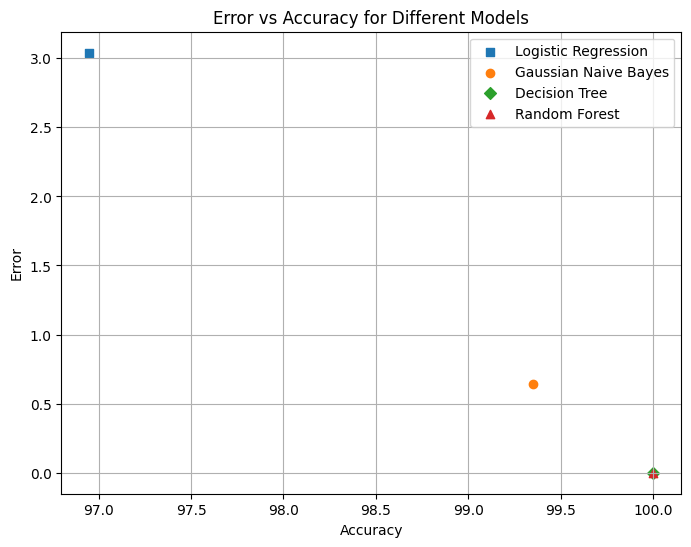

In [29]:
import matplotlib.pyplot as plt
Accuracies = [96.95, 99.35, 100.00, 100.00] # Accuracy in percentage
Errors = [3.04, 0.64, 0, 0] #Error in percentage
Models = ['Logistic Regression', 'Gaussian Naive Bayes', 'Decision Tree', 'Random Forest']

# Define marker shapes for each model
markers = ['s', 'o', 'D', '^']

# Create scatter plot with marker-coded legend
plt.figure(figsize=(8, 6))
for i, model in enumerate(Models):
    plt.scatter(Accuracies[i], Errors[i], marker=markers[i], label=model)

# Set plot title and labels
plt.title('Error vs Accuracy for Different Models')
plt.xlabel('Accuracy')
plt.ylabel('Error')

# Add legend
plt.legend(loc='upper right')

# Show plot
plt.grid(True)
plt.show()

# Limitation and Conclusion

The models showed promising findings, but given the restrictions of time and dataset size, consideration should be taken for avoiding overfitting. Furthermore, the lack of extensive hyperparameter optimisation underlines a need for additional improvement in the future. It is suggested that future research investigate unsupervised machine learning and deep learning modelsfor more in-depth analysis and development.